In [2]:
import yaml
import glob
import datetime


import matplotlib as mpl
import  matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import pandas as pd
import numpy as np
import networkx as nx

import hardwareModel
%load_ext autoreload
%autoreload 2

In [3]:
sns.set_theme(
    context="paper", style="white", palette="bright", rc={"figure.figsize": (5, 4)}
)
plt.rcParams["figure.dpi"] = 192
plt.rcParams["xtick.major.size"] = 0
plt.rcParams["ytick.major.size"] = 0

In [4]:
rng = np.random.default_rng(0)

In [9]:
def parse_log_file(log_file):
    forward_edp = []
    inverse_edp = []
    with open(log_file, "r") as f:
        lines = f.readlines()
    for line in lines:
        if "Forward EDP" in line:
            forward_edp.append(float(line.split(":")[-1].strip()))
        if "Inverse EDP" in line:
            inverse_edp.append(float(line.split(":")[-1].strip()))
    return len(forward_edp), forward_edp, inverse_edp

def get_latest_log_dir():
    log_dirs = glob.glob("codesign_log_dir/*-*-*_*-*-*")
    log_dirs = sorted(log_dirs, key=lambda x: datetime.datetime.strptime(x.split("/")[-1], "%Y-%m-%d_%H-%M-%S"))
    return log_dirs[-1]

In [61]:
year = 2024
month = 6
day = 20
hour = 15
minute = 55
sec = 49
log_dir = f"codesign_log_dir/{year}-{month:02}-{day:02}_{hour:02}-{minute:02}-{sec:02}"

log_dir = get_latest_log_dir()

print(log_dir)

num_iters, forward_edp, inverse_edp = parse_log_file(f"{log_dir}/results.txt")

edps = [val for pair in zip(forward_edp, inverse_edp) for val in pair]

codesign_log_dir/2024-06-24_10-36-14


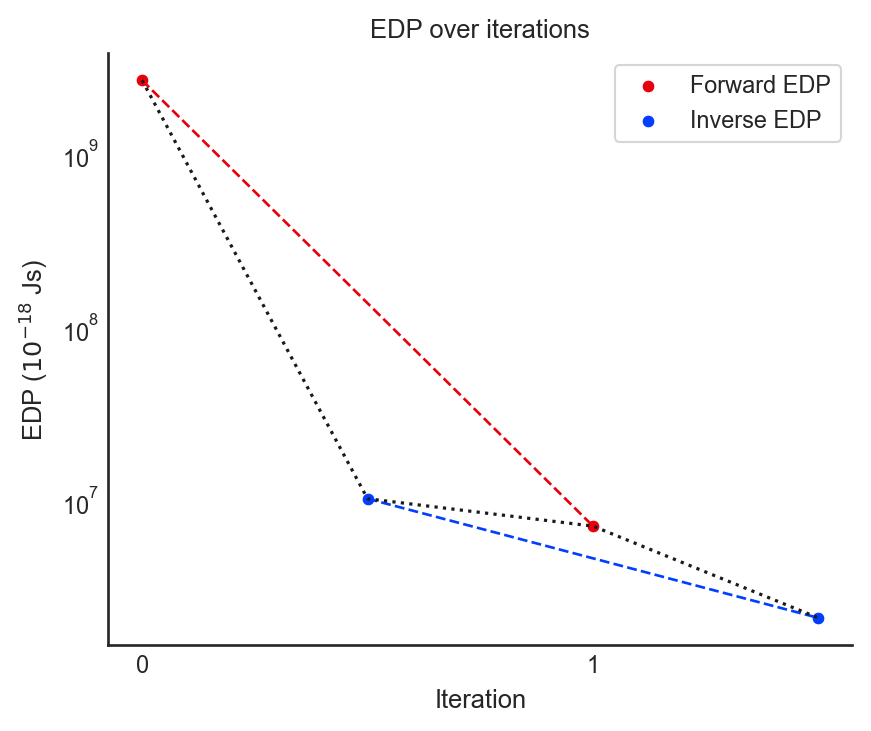

In [62]:
plt.title("EDP over iterations")
c = sns.scatterplot(x=range(num_iters), y=forward_edp, label="Forward EDP", c="r")
sns.lineplot(x=range(num_iters), y=forward_edp, linestyle="dashed", linewidth=1, c="r")
c = sns.scatterplot(
    x=np.arange(0.5, num_iters + 0.5), y=inverse_edp, label="Inverse EDP", c="b"
)
sns.lineplot(
    x=np.arange(0.5, num_iters + 0.5),
    y=inverse_edp,
    linestyle="dashed",
    linewidth=1,
    c="b",
)
sns.lineplot(x=np.arange(0, num_iters, 0.5), y=edps, linestyle="dotted", c="k")

sns.despine()

plt.xticks(range(num_iters))
plt.xlabel("Iteration")
plt.ylabel(r"EDP ($10^{-18}$ Js)")
plt.legend()
plt.yscale("log")
plt.savefig(f"{log_dir}/edp_over_iterations.png")
plt.show()

In [63]:
rcs = []
for i in range(num_iters):
    rcs.append(yaml.load(open(f"{log_dir}/rcs_{i}.yaml", "r"), Loader=yaml.Loader))

In [64]:
# remove all parameters in rcs that didn't change
keys = list(rcs[0]["Ceff"].keys())

for k in keys:
    val = rcs[0]["Ceff"][k]
    to_pop = True
    for i in range(1, num_iters):
        v = rcs[i]["Ceff"][k]
        to_pop &= v == val
        val = v
    if to_pop:
        for i in range(num_iters):
            rcs[i]["Ceff"].pop(k)

    val = rcs[0]["Reff"][k]
    to_pop = True
    for i in range(1, num_iters):
        v = rcs[i]["Reff"][k]
        to_pop &= v == val
        val = v
    if to_pop:
        for i in range(num_iters):
            rcs[i]["Reff"].pop(k)
print(rcs)

[{'Ceff': {'Add': 0.00012120587538417864, 'Mult': 0.005354073295329364, 'Regs': 1.3472380842798349e-05}, 'Reff': {'Add': 1173.0791093173082, 'Mult': 47.90773840632731, 'Not': 17539.04010197406, 'Regs': 60886.19627383142}, 'other': {'BufL': 0.5906917765456057, 'BufPpass': 0.00133685, 'BufReadEact': 1.12576870159792e-11, 'BufWriteEact': 1.3872034867221446e-11, 'MemPpass': 0.05147843977636998, 'MemReadEact': 3.222575657074312e-10, 'MemReadL': 1.9992231371150024, 'MemWriteEact': 3.39140772361443e-10, 'MemWriteL': 1.9992231371150082, 'OffChipIOL': 1.25e-18, 'OffChipIOPact': 2408160.0, 'V_dd': 0.8024416700477329}}, {'Ceff': {'Add': 6.293772407305004e-05, 'Mult': 0.002556441833127394, 'Regs': 1.247538284209485e-05}, 'Reff': {'Add': 609.1359230353049, 'Mult': 22.873314921685648, 'Not': 8373.896441886931, 'Regs': 56380.42718879476}, 'other': {'BufL': 0.29405617579189575, 'BufPpass': 0.00133685, 'BufReadEact': 5.374927495569487e-12, 'BufWriteEact': 6.623135065115441e-12, 'MemPpass': 0.0449230222

In [65]:
rc_df = pd.DataFrame(rcs)
print(rc_df.columns)

Index(['Ceff', 'Reff', 'other'], dtype='object')


In [66]:
def plot_from_rcs(k1, k2s, num_iters, rcs, title="", ylabel="", labels=[]):
    if type(k2s) is not list:
        k2s = [k2s]
    for i in range(len(k2s)):
        k2 = k2s[i]

        val = np.asarray(list(map(lambda x: float(x[k1][k2]), rcs)))
        # name = f"{k1}_{k2}" if k1 != "other" else k2
        val = val / val[0]
        if len(labels) != 0:
            lbl = labels[i]
        else:
            lbl = k2
        c = sns.scatterplot(x=range(num_iters), y=val, label=lbl)
        sns.lineplot(
            x=range(num_iters), y=val, linestyle="dotted", markers=True
        )  # c= c.get_facecolor())
    if title == "":
        title = f"{k1} over iterations"
    else:
        title += " over iterations"
    plt.title(title)
    sns.despine()

    # for i in range(num_iters):
    #     plt.scatter(rcs[i][k1], rcs[i][k2], label=f"iter {i}")
    plt.xlabel("Iteration")
    if ylabel == "":
        ylabel = f"{k1} (normalized)"
    else:
        ylabel += " (normalized)"
    plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(f"{log_dir}/{'_'.join(title.split(' '))}.png")
    plt.show()

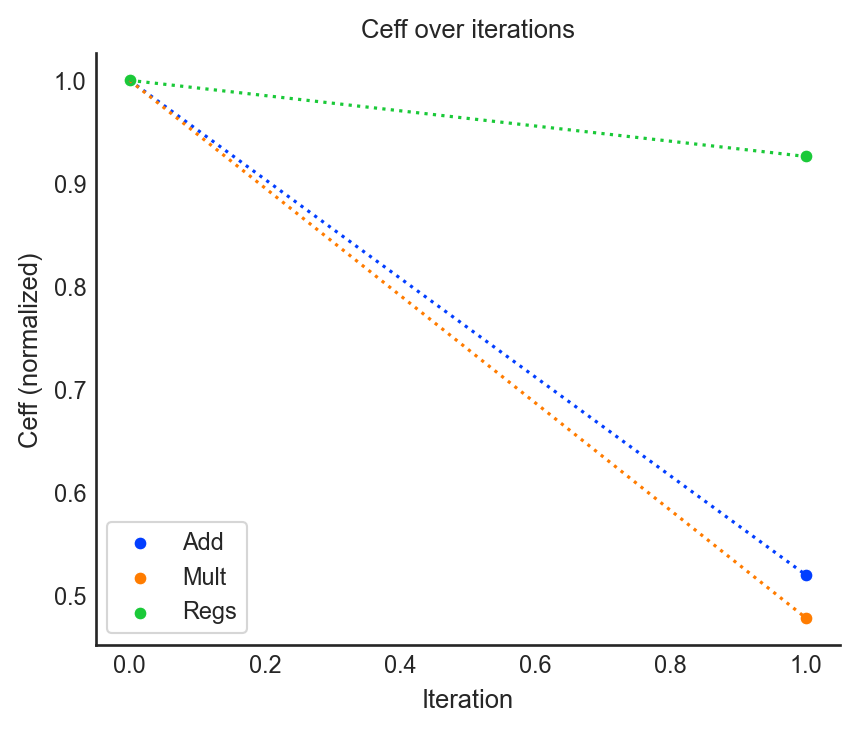

In [67]:
k1 = "Ceff"
k2s = list(rcs[0][k1].keys())

plot_from_rcs(k1, k2s, num_iters, rcs)

/var/folders/pb/xkf_1m6d4_b_x6511mct3t3r0000gn/T/ipykernel_57224/25122611.py:7: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):


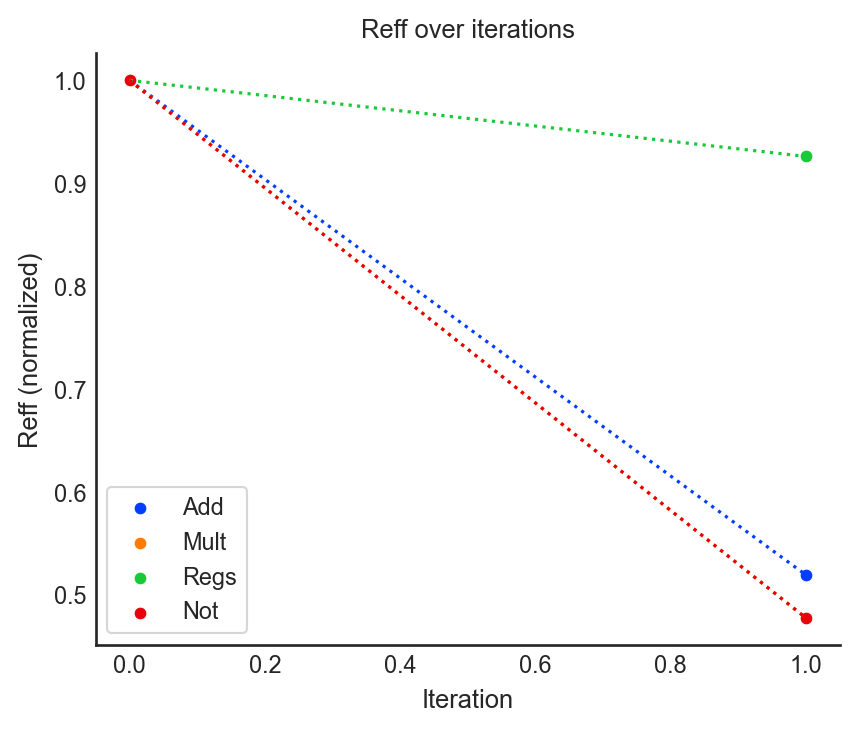

In [68]:
k1 = "Reff"
k2s = list(rcs[0][k1].keys())
tmp_idx = k2s.index("Not")
k2s.pop(tmp_idx)
k2s.append("Not")

with pd.option_context("mode.use_inf_as_na", True):
    plot_from_rcs(k1, k2s, num_iters, rcs)

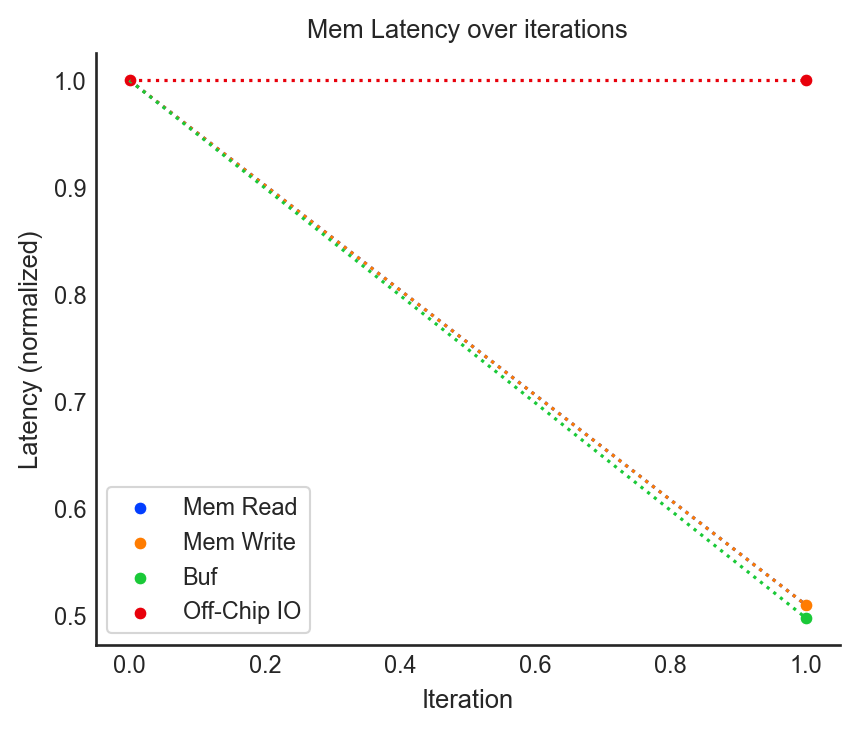

In [69]:
k1 = "other"
k2s = ["MemReadL", "MemWriteL", "BufL", "OffChipIOL"]
labels = ["Mem Read", "Mem Write", "Buf", "Off-Chip IO"]

plot_from_rcs(k1, k2s, num_iters, rcs, "Mem Latency", "Latency", labels)

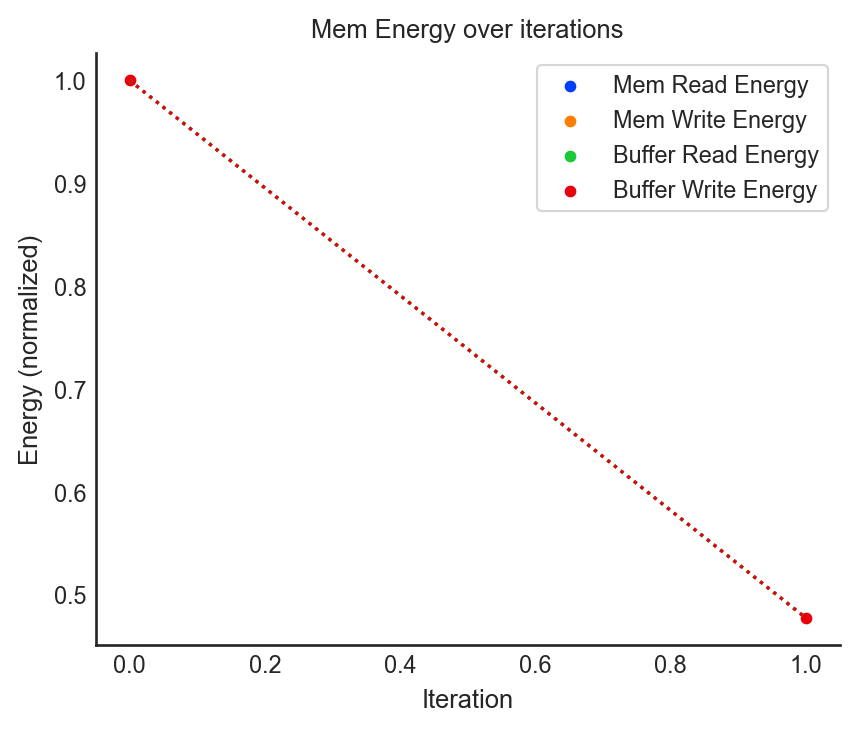

In [70]:
k1 = "other"
k2s = ["MemReadEact", "MemWriteEact", "BufReadEact", "BufWriteEact"]  # "MemPpass"]
labels = [
    "Mem Read Energy",
    "Mem Write Energy",
    "Buffer Read Energy",
    "Buffer Write Energy",
]  # "Passive"]

plot_from_rcs(k1, k2s, num_iters, rcs, "Mem Energy", "Energy", labels)

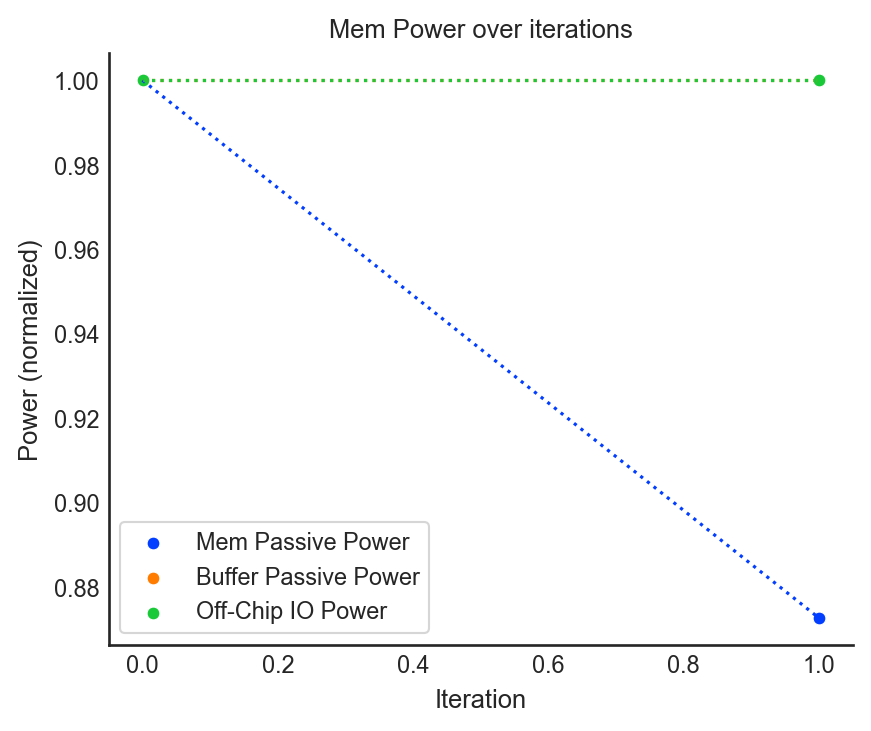

In [71]:
k1 = "other"
k2s = ["MemPpass", "BufPpass", "OffChipIOPact"]
labels = ["Mem Passive Power", "Buffer Passive Power", "Off-Chip IO Power"]

plot_from_rcs(k1, k2s, num_iters, rcs, "Mem Power", "Power", labels)

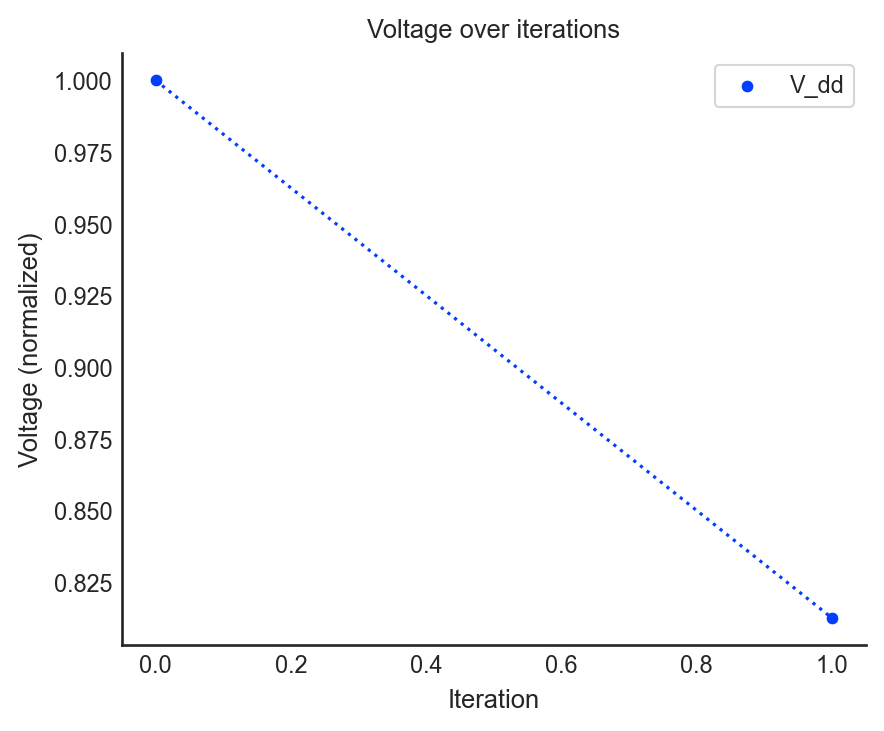

In [72]:
k1 = "other"
k2s = ["V_dd"]

plot_from_rcs(k1, k2s, num_iters, rcs, "Voltage", "Voltage")

#### Area

#### Get stalled node statistics

In [58]:
# Specify the directory path and the file format
file_format = 'schedule_*.gml'  # Replace with your desired file format

# Get a list of files with the specified format in the directory
files = sorted(glob.glob(log_dir + '/' + file_format))
schedule_node_counts = pd.DataFrame()
print(files)
# Print the list of files
for file in files:
    g = nx.read_gml(file)
    func_counts = hardwareModel.get_func_count(g)
    stall_nodes = hardwareModel.get_nodes_with_func(g, "stall")
    stall_funcs, counts = np.unique(list(map(lambda x: "stall_" + x.split("_")[3], stall_nodes.keys())), return_counts = True)
    assert func_counts["stall"] == counts.sum()
    stall_counts = dict(zip(stall_funcs, counts))
    dict_counts = {**func_counts, **stall_counts}
    schedule_node_counts = pd.concat(
        [schedule_node_counts, pd.DataFrame([dict_counts])], ignore_index=True
    )

print(schedule_node_counts)

['codesign_log_dir/2024-06-24_10-19-58/schedule_0.gml', 'codesign_log_dir/2024-06-24_10-19-58/schedule_1.gml', 'codesign_log_dir/2024-06-24_10-19-58/schedule_2.gml', 'codesign_log_dir/2024-06-24_10-19-58/schedule_3.gml', 'codesign_log_dir/2024-06-24_10-19-58/schedule_4.gml', 'codesign_log_dir/2024-06-24_10-19-58/schedule_5.gml', 'codesign_log_dir/2024-06-24_10-19-58/schedule_6.gml', 'codesign_log_dir/2024-06-24_10-19-58/schedule_7.gml', 'codesign_log_dir/2024-06-24_10-19-58/schedule_8.gml', 'codesign_log_dir/2024-06-24_10-19-58/schedule_9.gml']
   Mult  Add  MainMem  Buf  stall  Regs  end  stall_Add  stall_Buf  stall_Regs
0   125  150      450  450  69621   450    1       2921    50625.0       16075
1   125  150      450  450  18996   450    1       2921        NaN       16075
2   125  150      450  450   3265   450    1       3053        NaN         212
3   125  150      450  450   3265   450    1       3053        NaN         212
4   125  150      450  450   3265   450    1       305

['stall_Add', 'stall_Buf', 'stall_Regs']


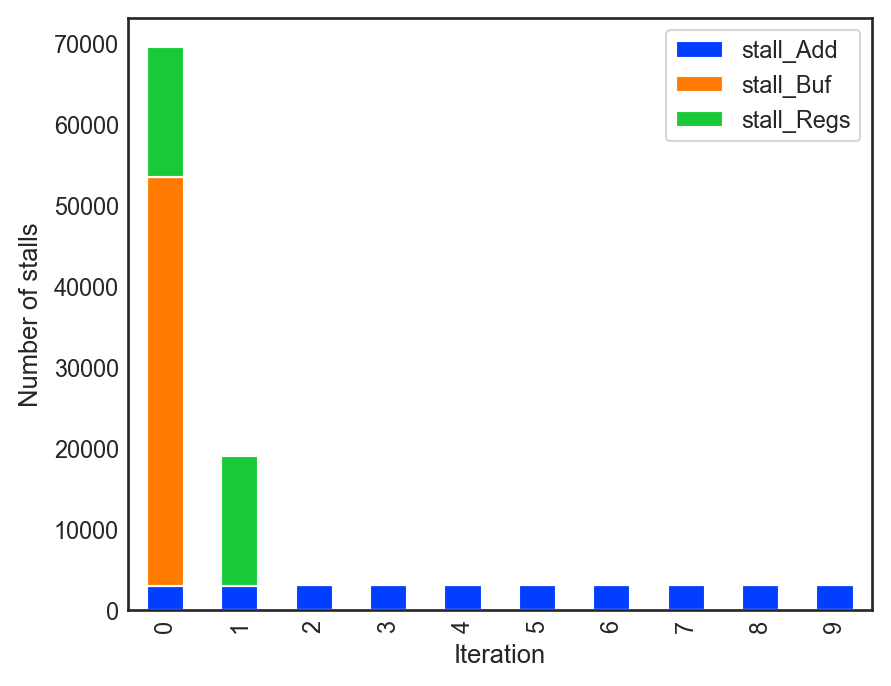

In [59]:
stall_columns = list(filter(lambda x: "stall_" in x, list(schedule_node_counts.columns)))
print(stall_columns)
schedule_node_counts[stall_columns].plot(kind="bar", stacked=True)
plt.xlabel("Iteration")
plt.ylabel("Number of stalls")
plt.savefig(f"{log_dir}/stalls_over_iterations.png")

#### Architecture Change Statistics

In [60]:
file_format = "netlist_*.gml"  # Replace with your desired file format

# Get a list of files with the specified format in the directory
files = sorted(glob.glob(log_dir + "/" + file_format))
netlist_function_counts = pd.DataFrame()

# Print the list of files
for file in files:
    g = nx.read_gml(file)
    func_counts = hardwareModel.get_func_count(g)
    netlist_function_counts = pd.concat(
        [netlist_function_counts, pd.DataFrame([func_counts])], ignore_index=True
    )

print(netlist_function_counts)

   Mult  Add  MainMem  Buf  Regs
0     1    1        1    1     2
1     1    1        2    2     2
2     1    1        3    3     3
3     1    1        3    3     3
4     1    1        3    3     3
5     1    1        3    3     3
6     1    1        3    3     3
7     1    1        3    3     3
8     1    1        3    3     3
9     1    1        3    3     3


#### Tech params

In [155]:
file_format = "tech_params*.yaml"  # Replace with your desired file format

# Get a list of files with the specified format in the directory
files = sorted(glob.glob(log_dir + "/" + file_format))
tech_params_df = pd.DataFrame()


def convert_tech_params_to_df(tech_params: dict, t: int) -> pd.DataFrame:
    """
    Returns a DF with index operator and iteration step.
    """
   
    area= []
    dynamic_power= []
    leakage_power= []
    dynamic_energy= []
    latency=[]
    operator= []
    T= []
     
    for key in tech_params["area"].keys():
        area.append(tech_params["area"][key])
        dynamic_power.append(tech_params["dynamic_power"][key] if key in tech_params["dynamic_power"] else np.nan)
        leakage_power.append(tech_params["leakage_power"][key] if key in tech_params["leakage_power"] else np.nan)
        dynamic_energy.append(tech_params["dynamic_energy"][key] if key in tech_params["dynamic_energy"] else np.nan)
        latency.append(tech_params["latency"][key] if key in tech_params["latency"] else np.nan)
        operator.append(key)
        T.append(t)
      

    for key in tech_params["dynamic_energy"].keys():
        for k2 in tech_params["dynamic_energy"][key].keys():
            area.append(np.nan)
            dynamic_power.append(np.nan)
            leakage_power.append(np.nan)
            dynamic_energy.append(tech_params["dynamic_energy"][key][k2] if k2 in tech_params["dynamic_energy"][key] else np.nan)
            latency.append(np.nan)
            operator.append(key + "_" + k2)
            T.append(t)

    ind = pd.MultiIndex.from_arrays([T, operator], names=("T", "Operator"))
    df = pd.DataFrame(
        {
            "Area": area,
            "Dynamic Power": dynamic_power,
            "Leakage Power": leakage_power,
            "Dynamic Energy": dynamic_energy,
            "Latency": latency,
        },
        index=ind,
    )                   
    return df


# Print the list of files
for t, file in enumerate(files):
    tp = yaml.load(open(file, "r"), Loader=yaml.Loader)
    tp_df = convert_tech_params_to_df(tp, t)
    tech_params_df = pd.concat([tech_params_df, tp_df])


print(tech_params_df)

                        Area  Dynamic Power  Leakage Power Dynamic Energy  \
T Operator                                                                  
0 Add            379348800.0  273029.471834    3325.527614            NaN   
  And             50369960.0    9599.291155     622.308549            NaN   
  BitAnd          50369960.0    9599.291155     622.308549            NaN   
  BitOr           50369960.0    9599.291155     622.308549            NaN   
  BitXor          50369960.0    9599.291155     622.308549            NaN   
...                      ...            ...            ...            ...   
9 USub           379348800.0   58782.433388    8489.657914            NaN   
  Buf_Read               NaN            NaN            NaN       0.001715   
  Buf_Write              NaN            NaN            NaN       0.002113   
  MainMem_Read           NaN            NaN            NaN       0.049079   
  MainMem_Write          NaN            NaN            NaN        0.05165   

lt operators: ['Buf', 'FloorDiv', 'LShift', 'Lt', 'MainMem', 'Mult', 'NotEq', 'RShift', 'Sub']
gt operators: ['And', 'Eq', 'Gt', 'Invert', 'Mod', 'Not', 'Regs']
eq operators: ['BitAnd', 'BitOr', 'BitXor', 'GtE', 'IsNot', 'LtE', 'UAdd', 'USub']


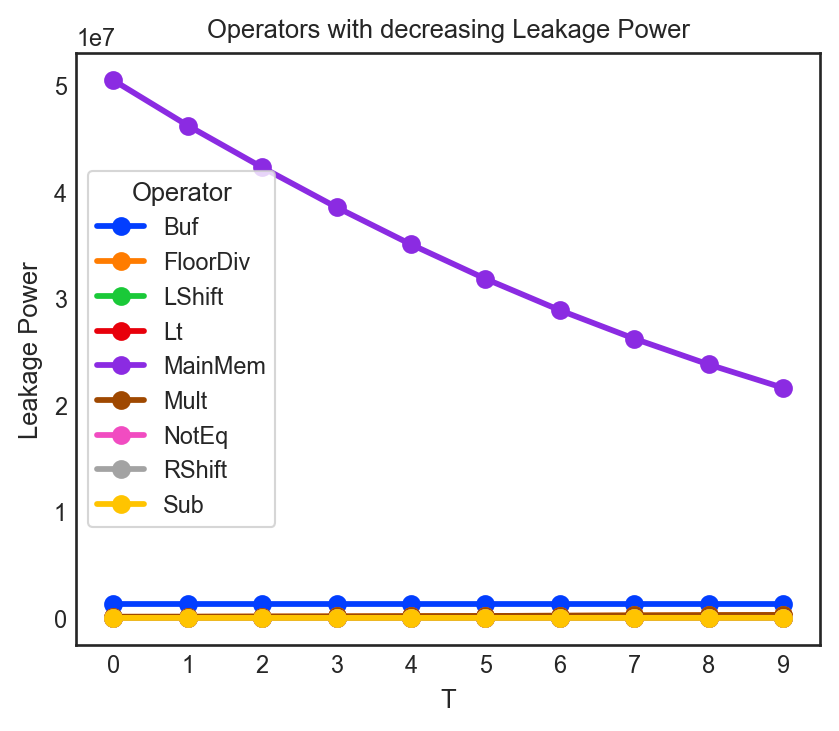

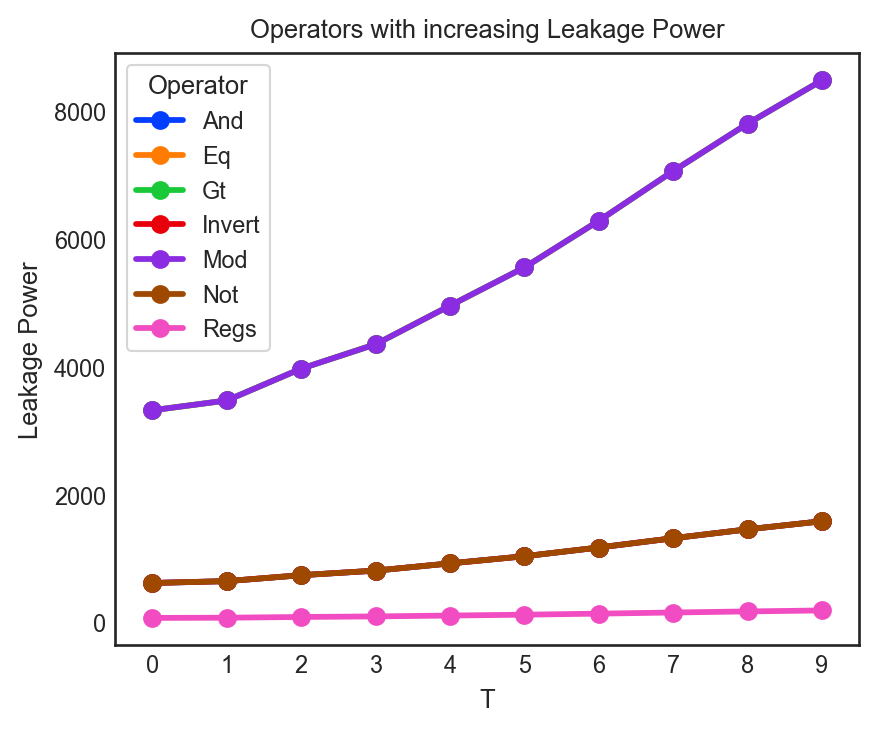

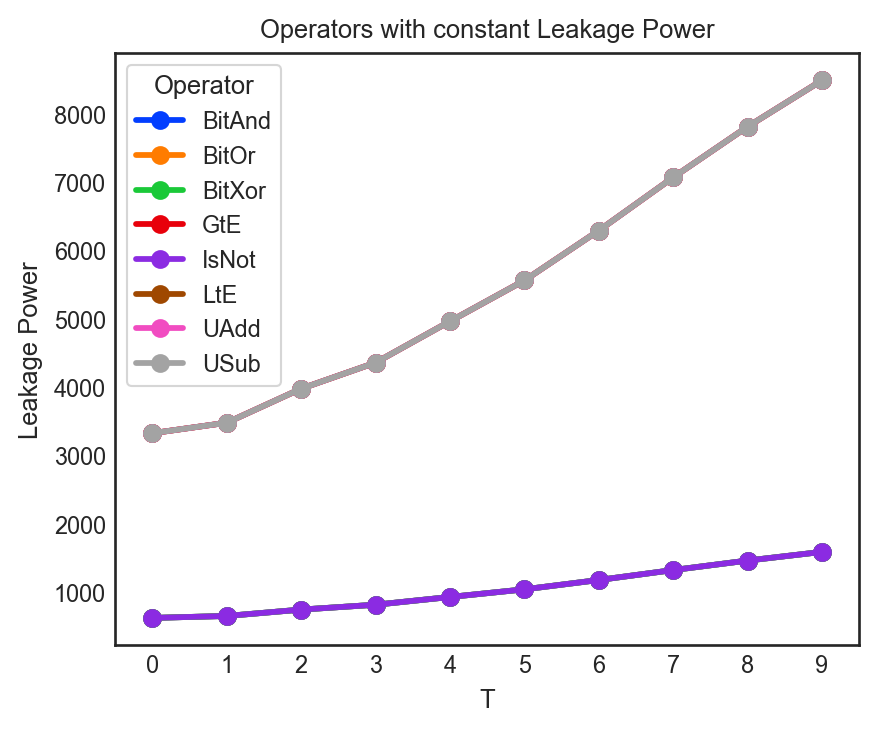

In [156]:
lt_operators = (
    tech_params_df[
        (tech_params_df.index.get_level_values("T") == t)
        & (tech_params_df["Leakage Power"] > tech_params_df["Leakage Power"].shift(1))
    ]
    .index.get_level_values("Operator")
    .tolist()
)
print(f"lt operators: {lt_operators}")
gt_operators = (
    tech_params_df[
        (tech_params_df.index.get_level_values("T") == t)
        & (tech_params_df["Leakage Power"] < tech_params_df["Leakage Power"].shift(1))
    ]
    .index.get_level_values("Operator")
    .tolist()
)
print(f"gt operators: {gt_operators}")
eq_operators = (
    tech_params_df[
        (tech_params_df.index.get_level_values("T") == t)
        & (tech_params_df["Leakage Power"] == tech_params_df["Leakage Power"].shift(1))
    ]
    .index.get_level_values("Operator")
    .tolist()
)
print(f"eq operators: {eq_operators}")

# operators = ['OffChipIO', "MainMem", "Buf", "Regs"]
sns.pointplot(
    data=tech_params_df[
        tech_params_df.index.get_level_values("Operator").isin(lt_operators)
    ],
    x="T",
    y="Leakage Power",
    hue="Operator",
)
plt.title("Operators with decreasing Leakage Power")
plt.show()
sns.pointplot(
    data=tech_params_df[
        tech_params_df.index.get_level_values("Operator").isin(gt_operators)
    ],
    x="T",
    y="Leakage Power",
    hue="Operator",
)
plt.title("Operators with increasing Leakage Power")
plt.show()
sns.pointplot(
    data=tech_params_df[
        tech_params_df.index.get_level_values("Operator").isin(eq_operators)
    ],
    x="T",
    y="Leakage Power",
    hue="Operator",
)
plt.title("Operators with constant Leakage Power")
plt.show()

In [157]:
tech_params_df[tech_params_df.index.get_level_values("Operator") == "FloorDiv"]["Latency"]

T  Operator
0  FloorDiv    0.49
1  FloorDiv    0.49
2  FloorDiv    0.49
3  FloorDiv    0.49
4  FloorDiv    0.49
5  FloorDiv    0.49
6  FloorDiv    0.49
7  FloorDiv    0.49
8  FloorDiv    0.49
9  FloorDiv    0.49
Name: Latency, dtype: float64